# Chapter 1 - Decision by Committee

Paul E. Anderson

In [63]:
%load_ext autoreload
%autoreload 2


from pathlib import Path
home = str(Path.home()) # all other paths are relative to this path. change to something else if this is not the case on your system

import sys
sys.path.insert(0,'..')

import py566

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<img src="https://s36369.pcdn.co/wp-content/uploads/2018/11/Two-heads-are-better-than-one-HP.jpg">

**Definition:** Ensemble learning is a type of learning that combines a set/ensemble of learners to reach a prediction.

## Two main types of ensemble learning

<img src="https://miro.medium.com/max/2000/1*zTgGBTQIMlASWm5QuS2UpA.jpeg">

One thing all these methods have to decide is how to get different models from the same dataset. Bagging gets the different models by dividing up the training data. Boosting gets different models by training a series of models on the residual of the previous model.

## Bagging
Bagging stands for bootstrap aggregating. 

So what is a bootstrap? A bootstrap sample is a sample taken from the original dataset with replacement. A new dataset created with boostrap sampling is the same size as the original. 

This is completely different from a bootstrap loader from computer science. 

So why would duplicating samples do us any good? If we do this multiple times and create a new classifier each time, then we will have our ensemble!

**Loading a dataset**

In [31]:
import pandas as pd
import numpy as np

titanic_df = pd.read_csv(
    f"../data/titanic.csv"
)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Cleaning and modifying the data**

In [4]:
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']
titanic_df2 = titanic_df.loc[:,features]
titanic_df2['CabinLetter'] = titanic_df2['Cabin'].str.slice(0,1)
X = titanic_df2.drop('Cabin',axis=1)
X['CabinLetter'] = X['CabinLetter'].fillna("?")
X['Pclass'] = X['Pclass'].astype(str)
X['SibSp'] = X['SibSp'].astype(str)
X['Parch'] = X['Parch'].astype(str)
X['Age'] = ((X['Age'].fillna(X['Age'].mean())/10).astype(int)*10).astype(int).astype(str)

X = X.dropna()
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinLetter
0,3,male,20,1,0,7.2500,S,?
1,1,female,30,1,0,71.2833,C,C
2,3,female,20,0,0,7.9250,S,?
3,1,female,30,1,0,53.1000,S,C
4,3,male,30,0,0,8.0500,S,?


In [5]:
X.dtypes

Pclass          object
Sex             object
Age             object
SibSp           object
Parch           object
Fare           float64
Embarked        object
CabinLetter     object
dtype: object

**Creating and fitting a very simple guess-the-mean regressor**

In [6]:
reg = py566.base.MeanRegressor()
reg.fit(X,X['Fare'])

MeanRegressor()

**How would we evaluate this model?**

In [7]:
X2 = X.drop(columns='Fare')
X2.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked,CabinLetter
0,3,male,20,1,0,S,?
1,1,female,30,1,0,C,C
2,3,female,20,0,0,S,?
3,1,female,30,1,0,S,C
4,3,male,30,0,0,S,?


In [8]:
t = X['Fare']
t.head()

0     7.2500
1    71.2833
2     7.9250
3    53.1000
4     8.0500
Name: Fare, dtype: float64

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, t_train, t_test = train_test_split(X2, t, test_size=0.33, random_state=42)

pd.DataFrame(X_train).to_csv("X_train.csv")
pd.DataFrame(X_test).to_csv("X_test.csv")
pd.DataFrame(t_train).to_csv("t_train.csv")
pd.DataFrame(t_test).to_csv("t_test.csv")

In [10]:
from sklearn.metrics import mean_absolute_error

In [11]:
results = [] # Example: {'Method':,'Train MAE':, 'Test MAE':}

In [27]:
reg = py566.base.MeanRegressor()
reg.fit(X_train,t_train)
results.append({'Method':'MeanRegressor',
                'Train MAE':mean_absolute_error(t_train,reg.predict(X_train)),
                'Test MAE':mean_absolute_error(t_test,reg.predict(X_test))})
pd.DataFrame(results)

,Method,Train MAE,Test MAE
0,MeanRegressor,29.072397,27.099761
1,StumpRegressor,19.839588,17.972227
2,BaggingMeanRegressor 10,29.409289,27.441958
3,BaggingStumpRegressor 10,19.907215,17.984370
4,BaggingStumpRegressor 100,19.783660,17.875548
5,BaggingStumpRegressor 100,78.824762,77.179592
6,MeanRegressor,29.072397,27.099761
7,MeanRegressor,29.072397,27.099761
8,MeanRegressor,29.072397,27.099761
9,MeanRegressor,29.072397,27.099761


In [13]:
display(X_train, t_train)

,Pclass,Sex,Age,SibSp,Parch,Embarked,CabinLetter
6,1,male,50,0,0,S,E
576,2,female,30,0,0,S,?
445,1,male,0,0,2,S,A
74,3,male,30,0,0,S,?
670,2,female,40,1,1,S,?
...,...,...,...,...,...,...,...
107,3,male,20,0,0,S,?
271,3,male,20,0,0,S,?
862,1,female,40,0,0,S,D
436,3,female,20,2,2,S,?


6      51.8625
576    13.0000
445    81.8583
74     56.4958
670    39.0000
        ...   
107     7.7750
271     0.0000
862    25.9292
436    34.3750
103     8.6542
Name: Fare, Length: 595, dtype: float64

**Stump Regressor**

In [14]:
reg = py566.tree.StumpRegressor()
reg.fit(X_train,t_train)
results.append({'Method':'StumpRegressor',
                'Train MAE':mean_absolute_error(t_train,reg.predict(X_train)),
                'Test MAE':mean_absolute_error(t_test,reg.predict(X_test))})
pd.DataFrame(results)

,Method,Train MAE,Test MAE
0,MeanRegressor,29.072397,27.099761
1,StumpRegressor,19.839588,17.972227


**Bagging**

In [29]:
reg = py566.ensemble.BaggingRegressor()
reg.fit(X_train,t_train)
results.append({'Method':'BaggingMeanRegressor 10',
                'Train MAE':mean_absolute_error(t_train,reg.predict(X_train)),
                'Test MAE':mean_absolute_error(t_test,reg.predict(X_test))})
pd.DataFrame(results)

,Method,Train MAE,Test MAE
0,MeanRegressor,29.072397,27.099761
1,StumpRegressor,19.839588,17.972227
2,BaggingMeanRegressor 10,29.409289,27.441958
3,BaggingStumpRegressor 10,19.907215,17.984370
4,BaggingStumpRegressor 100,19.783660,17.875548
5,BaggingStumpRegressor 100,78.824762,77.179592
6,MeanRegressor,29.072397,27.099761
7,MeanRegressor,29.072397,27.099761
8,MeanRegressor,29.072397,27.099761
9,MeanRegressor,29.072397,27.099761


In [16]:
reg = py566.ensemble.BaggingRegressor(get_learner_func=lambda: py566.tree.StumpRegressor())
reg.fit(X_train,t_train)
results.append({'Method':'BaggingStumpRegressor 10',
                'Train MAE':mean_absolute_error(t_train,reg.predict(X_train)),
                'Test MAE':mean_absolute_error(t_test,reg.predict(X_test))})
pd.DataFrame(results)

,Method,Train MAE,Test MAE
0,MeanRegressor,29.072397,27.099761
1,StumpRegressor,19.839588,17.972227
2,BaggingMeanRegressor 10,29.409289,27.441958
3,BaggingStumpRegressor 10,19.907215,17.984370


In [17]:
reg = py566.ensemble.BaggingRegressor(ntrees=100,get_learner_func=lambda: py566.tree.StumpRegressor())
reg.fit(X_train,t_train)
results.append({'Method':'BaggingStumpRegressor 100',
                'Train MAE':mean_absolute_error(t_train,reg.predict(X_train)),
                'Test MAE':mean_absolute_error(t_test,reg.predict(X_test))})
pd.DataFrame(results)

,Method,Train MAE,Test MAE
0,MeanRegressor,29.072397,27.099761
1,StumpRegressor,19.839588,17.972227
2,BaggingMeanRegressor 10,29.409289,27.441958
3,BaggingStumpRegressor 10,19.907215,17.984370
4,BaggingStumpRegressor 100,19.783660,17.875548


In [ ]:
# End of notebook
reg = py566.ensemble_parallel.BaggingRegressor(ntrees=10,get_learner_func=lambda: py566.tree.StumpRegressor())
from py566.ensemble_parallel import fit

fit(X_train,t_train)

results.append({'Method':'BaggingStumpRegressor 100',
                'Train MAE':mean_absolute_error(t_train,reg.predict(X_train)),
                'Test MAE':mean_absolute_error(t_test,reg.predict(X_test))})
pd.DataFrame(results)

xy     Pclass     Sex Age SibSp Parch Embarked CabinLetter
6        1    male  50     0     0        S           E
576      2  female  30     0     0        S           ?
445      1    male   0     0     2        S           A
74       3    male  30     0     0        S           ?
670      2  female  40     1     1        S           ?
..     ...     ...  ..   ...   ...      ...         ...
107      3    male  20     0     0        S           ?
271      3    male  20     0     0        S           ?
862      1  female  40     0     0        S           D
436      3  female  20     2     2        S           ?
103      3    male  30     0     0        S           ?

[595 rows x 7 columns] 6      51.8625
576    13.0000
445    81.8583
74     56.4958
670    39.0000
        ...   
107     7.7750
271     0.0000
862    25.9292
436    34.3750
103     8.6542
Name: Fare, Length: 595, dtype: float64


(fit_one_tree pid=7165) 2023-01-20 12:56:00,019	ERROR serialization.py:371 -- No module named 'py566'

RayTaskError: [36mray::fit_one_tree()[39m (pid=7160, ip=127.0.0.1)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.RaySystemError: System error: No module named 'py566'
traceback: Traceback (most recent call last):
ModuleNotFoundError: No module named 'py566'


(fit_one_tree pid=7165) Traceback (most recent call last):
(fit_one_tree pid=7165)   File "/Users/MichaelMoschitto/Desktop/566/.venv/lib/python3.9/site-packages/ray/_private/serialization.py", line 369, in deserialize_objects
(fit_one_tree pid=7165)     obj = self._deserialize_object(data, metadata, object_ref)
(fit_one_tree pid=7165)   File "/Users/MichaelMoschitto/Desktop/566/.venv/lib/python3.9/site-packages/ray/_private/serialization.py", line 252, in _deserialize_object
(fit_one_tree pid=7165)     return self._deserialize_msgpack_data(data, metadata_fields)
(fit_one_tree pid=7165)   File "/Users/MichaelMoschitto/Desktop/566/.venv/lib/python3.9/site-packages/ray/_private/serialization.py", line 207, in _deserialize_msgpack_data
(fit_one_tree pid=7165)     python_objects = self._deserialize_pickle5_data(pickle5_data)
(fit_one_tree pid=7165)   File "/Users/MichaelMoschitto/Desktop/566/.venv/lib/python3.9/site-packages/ray/_private/serialization.py", line 197, in _deserialize_pickle5

2023-01-20 12:56:05,988	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::fit_one_tree() (pid=7163, ip=127.0.0.1)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.RaySystemError: System error: No module named 'py566'
traceback: Traceback (most recent call last):
ModuleNotFoundError: No module named 'py566'
2023-01-20 12:56:05,990	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::fit_one_tree() (pid=7161, ip=127.0.0.1)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.RaySystemError: System error: No module named 'py566'
traceback: Traceback (most recent call last):
ModuleNotFoundError: No module named 'py566'
2023-01-20 12:56:05,991	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::fit_one_tree() (pid=7165, ip=127.0.0.1)
  At least one of the input arguments for this task could n

-----
Decision Tree

## Results

Random forest with 100 trees did better than a single tree by precision, accuracy, and f1. Recall was the same. 

**Decision Tree**<br>
precision: 0.711<br>
recall: 0.719<br>
accuracy: 0.761<br>
f1: 0.715<br><br>


**Random Forest**<br>
precision: 0.735<br>
recall: 0.719<br>
accuracy: 0.775<br>
f1: 0.727<br>

In [71]:
def format_data():
    features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']
    titanic_df2 = titanic_df.loc[:,features]
    titanic_df2['CabinLetter'] = titanic_df2['Cabin'].str.slice(0,1)
    X = titanic_df2.drop('Cabin',axis=1)#.dropna()
    X['CabinLetter'] = X['CabinLetter'].fillna("?")
    X['Pclass'] = X['Pclass'].astype(str)
    X['SibSp'] = X['SibSp'].astype(str)
    X['Parch'] = X['Parch'].astype(str)
    X = X.dropna()
    X2 = X.copy()
    X2['Age'] = pd.cut(X2['Age'],bins=20).astype(str) # bin Age up
    X2['Age'].value_counts()
    X2['Fare'] = pd.cut(X2['Fare'],bins=20).astype(str) # bin Age up
    X2['Fare'].value_counts()
    t = titanic_df.loc[X2.index,'Survived']

    return X2, t

In [82]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns
def seaborn_conf_matrix(cm):
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

def print_metrics(y_test, y_pred):
    output = f"""precision: {precision_score(y_test, y_pred)}\nrecall: {recall_score(y_test, y_pred)}\naccuracy: {accuracy_score(y_test, y_pred)}\nf1: {f1_score(y_test, y_pred)}"""
    print(output)


def print_all_metrics(y_test, yhat, classifier=True):
    print(f'\n\n-----MODULE {"CLASSIFICATION" if classifier else "PREDICTION"} METRICS-----')
    if classifier:    
        print_metrics(y_test, yhat)
        seaborn_conf_matrix(confusion_matrix(y_test, yhat))




-----MODULE CLASSIFICATION METRICS-----
precision: 0.7111111111111111
recall: 0.7191011235955056
accuracy: 0.7616822429906542
f1: 0.7150837988826815


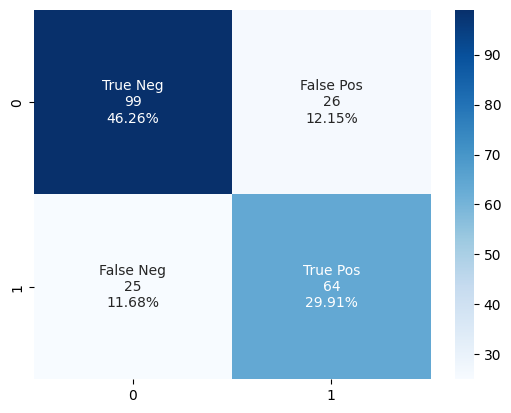

In [85]:


from py566 import Lab4_helper
from py566 import Lab3_helper
from sklearn.metrics import confusion_matrix

titanic_df = pd.read_csv(
    f"../data/titanic.csv"
)

default = 0
from sklearn.model_selection import train_test_split

X2, t = format_data()

reg = py566.decision_tree.DecisionTree()


X_train, X_test, t_train, t_test = train_test_split(X2, t, test_size=0.3, random_state = 0)
X_train, X_test = X.loc[X_train.index], X.loc[X_test.index]
reg.fit(X_train, t_train)
t_pred = reg.predict(X_test)

print_all_metrics(t_test, t_pred, classifier=True)




-----MODULE CLASSIFICATION METRICS-----
precision: 0.735632183908046
recall: 0.7191011235955056
accuracy: 0.7757009345794392
f1: 0.7272727272727273


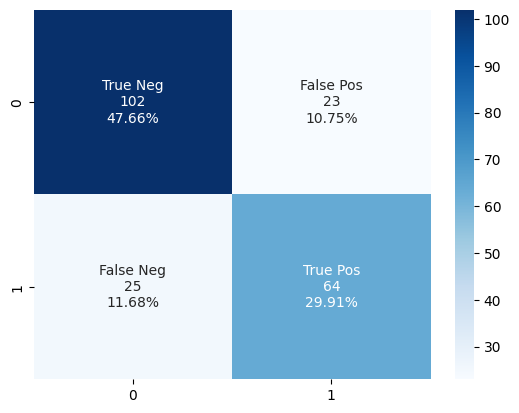

In [105]:
reg = py566.ensemble.BaggingRegressor(ntrees=100,get_learner_func=lambda: py566.decision_tree.DecisionTree())

X_train, X_test, t_train, t_test = train_test_split(X2, t, test_size=0.3, random_state = 0)
X_train, X_test = X.loc[X_train.index], X.loc[X_test.index]
reg.fit(X_train, t_train)
t_pred = reg.predict(X_test, random_forest=True) 

print_all_metrics(t_test, t_pred, classifier=True)